In [1]:
import numpy as np
from implementations import *
from helpers import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
old_dataset, _, y_train, train_ids, test_ids = load_csv_data(data_path='data/dataset')
y_train = np.where(y_train == -1, 0, 1)
x_train = np.load('data/cleaned_data/cleaned_x_train.npy')
x_train_norm = standardize(x_train)
x_train_norm = np.hstack((np.reshape(np.ones(x_train_norm.shape[0]), (x_train_norm.shape[0],1)), x_train_norm))

N, D = x_train_norm.shape

In [3]:
def calculate_metrics(y_true, y_pred):
    tp = np.sum(np.logical_and(y_true == 1, y_pred == 1))
    tn = np.sum(np.logical_and(y_true == 0, y_pred == 0))
    fp = np.sum(np.logical_and(y_true == 0, y_pred == 1))
    fn = np.sum(np.logical_and(y_true == 1, y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    return accuracy, precision, recall, f1

In [4]:
# these functions are the the exact same as in the implementations.py file,
# I just add the loss tracking to pretty print the loss
# I also remove printing the loss

# always FULL GRADIENT

# linear regression
def mean_squared_error_gd (y, tx, initial_w, max_iters, gamma) :
    losses = np.zeros(max_iters)
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_mse_loss(y, tx, w)
        # print(f"At iteration {n_iter}, loss = {loss}")
        gradient = compute_gradient(y, tx, w)
        w = w - gamma * gradient
        losses[n_iter] = loss
        
    return w, losses
    
# logistic regression
def logistic_regression_gd (y, tx, initial_w, max_iters, gamma, weight0 = 1, weight1 = 1) :
    losses = np.zeros(max_iters)   
    w = initial_w
    for i in range(max_iters):
        loss = loss_logistic_regression(y, tx, w, weight0, weight1)
        gradient = calculate_gradient_logistic_regression_weights(y, tx, w, weight0, weight1)
        # print(f"At iteration {i}, loss = {loss}")
        w = w - gamma * gradient
        losses[i] = loss    

    return w, losses

### pilot run

In [ ]:
MAX_ITERS = 1000
LEARNING_RATE = 0.05
INITIAL_W = np.ones(x_train_norm.shape[1])

_, losses_linear = mean_squared_error_gd(y_train, x_train_norm, INITIAL_W, MAX_ITERS, LEARNING_RATE)
_, losses_logistic = logistic_regression_gd(y_train, x_train_norm, INITIAL_W, MAX_ITERS, LEARNING_RATE)

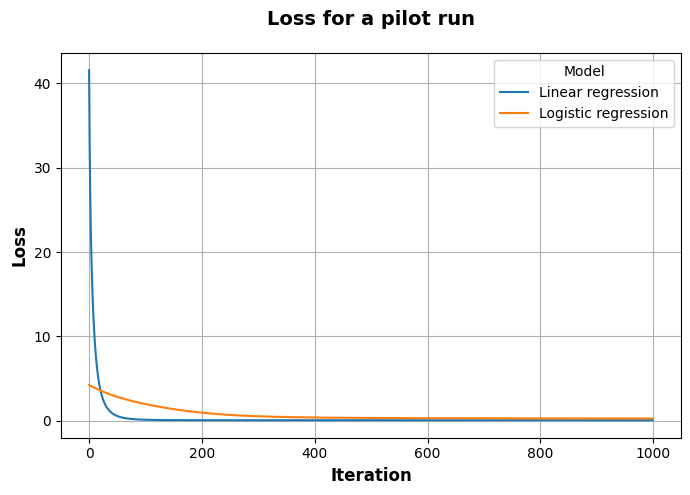

In [8]:
plt.figure(figsize=(8,5))
plt.plot(losses_linear, label=f"Linear regression")
plt.plot(losses_logistic, label=f"Logistic regression")
plt.xlabel('Iteration', fontsize=12, weight='bold')
plt.ylabel('Loss', fontsize=12, weight='bold')
plt.title('Loss for a pilot run', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model")
plt.grid()

plt.savefig("img_notturne\\pilot_run.pdf")

### Cross validation for p

In [6]:
def balanced_k_folds(y, n_folds):
    fold_indeces = []
    c1_indeces = np.where(y == 1)[0]
    np.random.shuffle(c1_indeces)
    c0_indeces = np.where(y == 0)[0]
    np.random.shuffle(c0_indeces)
    q1 = c1_indeces.shape[0] // n_folds
    r1 = c1_indeces.shape[0] % n_folds
    for i in range(n_folds):
        fold_indeces.append(c1_indeces[i*q1 : (i+1)*q1])
    for i in range(r1):
        fold_indeces[i] = np.append(fold_indeces[i], c1_indeces[n_folds*q1 + i])
    q0 = c0_indeces.shape[0] // n_folds
    r0 = c0_indeces.shape[0] % n_folds
    for i in range(n_folds):
        fold_indeces[i] = np.concatenate((fold_indeces[i], c0_indeces[i*q0 : (i+1)*q0]))
    for i in range(r0):
        # print(f"c1 indices len {len(c1_indeces)}")
        # print(n_folds*q0 + i)
        fold_indeces[i] = np.append(fold_indeces[i], c0_indeces[n_folds*q0 + i])
    
    # sanity checks
    assert y.shape[0] == sum(fold.shape[0] for fold in fold_indeces)
    for i in range(n_folds):
        for j in range(i+1, n_folds):
            assert np.intersect1d(fold_indeces[i], fold_indeces[j]).shape[0] == 0
    
    return fold_indeces
    

def remove_percentage(X, Y, keep_percentage):
    # remove row to train on full dataset
    zero_rows = X[Y == 0]
    one_rows = X[Y == 1]
    num_keep = int(len(zero_rows)* keep_percentage)
    idx_to_keep = np.random.choice(zero_rows.shape[0], num_keep, replace=False )
    zero_rows_keep = zero_rows[idx_to_keep]
    train_x_small = np.concatenate((zero_rows_keep, one_rows), axis=0)
    train_y_small = np.concatenate((np.zeros(num_keep), np.ones(one_rows.shape[0])))

    return train_x_small, train_y_small
    
    
def accuracy_f1(y, tx, w, threshold):
    pred = sigmoid(tx @ w)
    pred[pred > threshold] = 1
    pred[pred <= threshold] = 0
    accuracy = np.mean(y == pred)
    precision = np.sum((y == 1) & (pred == 1)) / np.sum(pred)
    recall = np.sum((y == 1) & (pred == 1)) / np.sum(y)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, f1


Linear regression

In [32]:
PERCENTAGES = [0.1, 0.3,  0.5, 0.7, 0.9]
N_FOLDS = 4
THRESHOLD = 0.5
MAX_ITERS = 1000
INITIAL_W = np.ones(D)

lin_train_losses = np.zeros(len(PERCENTAGES))
lin_val_losses = np.zeros(len(PERCENTAGES))
lin_f1s = np.zeros(len(PERCENTAGES))
lin_accuracies = np.zeros(len(PERCENTAGES))

folds = balanced_k_folds(y_train, N_FOLDS)

for j, p in enumerate(PERCENTAGES):
    p_train_losses = np.zeros(N_FOLDS)
    p_val_losses = np.zeros(N_FOLDS)
    p_f1s = np.zeros(N_FOLDS)
    p_accuracies = np.zeros(N_FOLDS)
    
    for i in tqdm(range(N_FOLDS)):
        fold = folds[i]
        rest = np.setdiff1d(np.arange(N), fold)
            
        loc_y_val = y_train[fold]
        loc_x_val = x_train_norm[fold, :]
        loc_y_train = y_train[rest]
        loc_x_train = x_train_norm[rest, :]
        loc_x_train, loc_y_train = remove_percentage(loc_x_train, loc_y_train, p)

        w, loc_train_losses =  mean_squared_error_gd(loc_y_train, loc_x_train, INITIAL_W, MAX_ITERS, LEARNING_RATE)
        p_train_losses[i] = loc_train_losses[-1]
        p_val_losses[i] = compute_mse_loss(loc_y_val, loc_x_val, w)
        
        pred = (loc_x_val @ w) > THRESHOLD
        p_accuracies[i], p_f1s[i] = accuracy_f1(loc_y_val, loc_x_val, w, THRESHOLD)
        
    lin_train_losses[j] = np.mean(p_train_losses)
    lin_val_losses[j] = np.mean(p_val_losses)
    lin_f1s[j] = np.mean(p_f1s)
    lin_accuracies[j] = np.mean(p_accuracies)

100%|██████████| 4/4 [02:48<00:00, 42.22s/it]


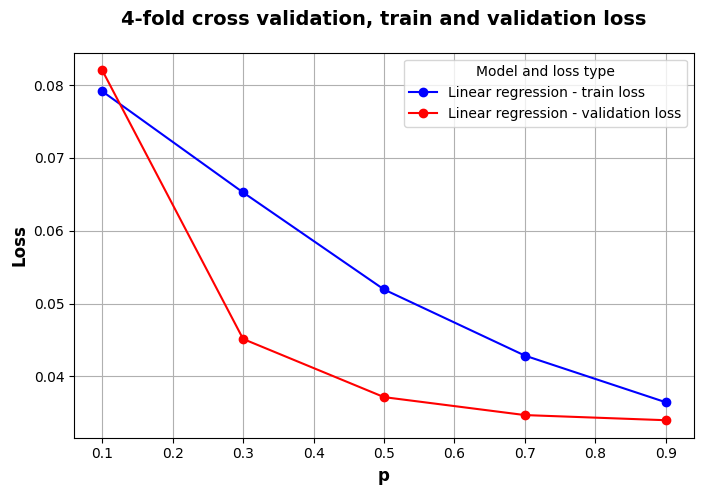

In [33]:
plt.figure(figsize=(8,5))
plt.plot(PERCENTAGES, lin_train_losses, 'bo-', label=f'Linear regression - train loss')
plt.plot(PERCENTAGES, lin_val_losses, 'ro-', label=f'Linear regression - validation loss')
plt.xlabel('p', fontsize=12, weight='bold')
plt.ylabel('Loss',  fontsize=12, weight='bold')
plt.title(f'{N_FOLDS}-fold cross validation, train and validation loss', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model and loss type")
plt.grid(True)
plt.show()

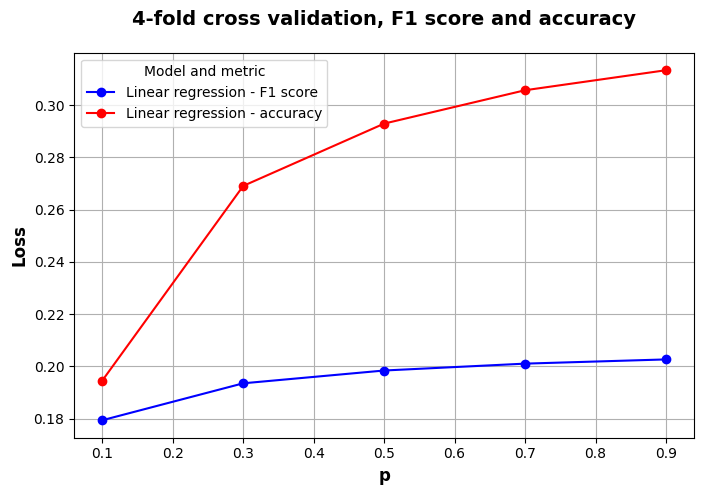

In [34]:
plt.figure(figsize=(8,5))
plt.plot(PERCENTAGES, lin_f1s, 'bo-', label=f'Linear regression - F1 score')
plt.plot(PERCENTAGES, lin_accuracies, 'ro-', label=f'Linear regression - accuracy')
plt.xlabel('p', fontsize=12, weight='bold')
plt.ylabel('Loss',  fontsize=12, weight='bold')
plt.title(f'{N_FOLDS}-fold cross validation, F1 score and accuracy', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model and metric")
plt.grid(True)
plt.show()

Logistic regression

In [35]:
PERCENTAGES = [0.1, 0.3,  0.5, 0.7, 0.9]
N_FOLDS = 4
THRESHOLD = 0.5
MAX_ITERS = 1000
INITIAL_W = np.ones(D)

log_train_losses = np.zeros(len(PERCENTAGES))
log_val_losses = np.zeros(len(PERCENTAGES))
log_f1s = np.zeros(len(PERCENTAGES))
log_accuracies = np.zeros(len(PERCENTAGES))

# use the same folds as before
# folds = balanced_k_folds(y_train, N_FOLDS)

for j, p in enumerate(PERCENTAGES):
    p_train_losses = np.zeros(N_FOLDS)
    p_val_losses = np.zeros(N_FOLDS)
    p_f1s = np.zeros(N_FOLDS)
    p_accuracies = np.zeros(N_FOLDS)
    
    for i in tqdm(range(N_FOLDS)):
        fold = folds[i]
        rest = np.setdiff1d(np.arange(N), fold)
            
        loc_y_val = y_train[fold]
        loc_x_val = x_train_norm[fold, :]
        loc_y_train = y_train[rest]
        loc_x_train = x_train_norm[rest, :]
        loc_x_train, loc_y_train = remove_percentage(loc_x_train, loc_y_train, p)

        w, loc_train_losses =  logistic_regression_gd(loc_y_train, loc_x_train, INITIAL_W, MAX_ITERS, LEARNING_RATE)
        p_train_losses[i] = loc_train_losses[-1]
        p_val_losses[i] = loss_logistic_regression(loc_y_val, loc_x_val, w)
        
        pred = sigmoid(loc_x_val @ w) > THRESHOLD
        p_accuracies[i], p_f1s[i] = accuracy_f1(loc_y_val, loc_x_val, w, THRESHOLD)
        
    log_train_losses[j] = np.mean(p_train_losses)
    log_val_losses[j] = np.mean(p_val_losses)
    log_f1s[j] = np.mean(p_f1s)
    log_accuracies[j] = np.mean(p_accuracies)

100%|██████████| 4/4 [05:36<00:00, 84.09s/it]


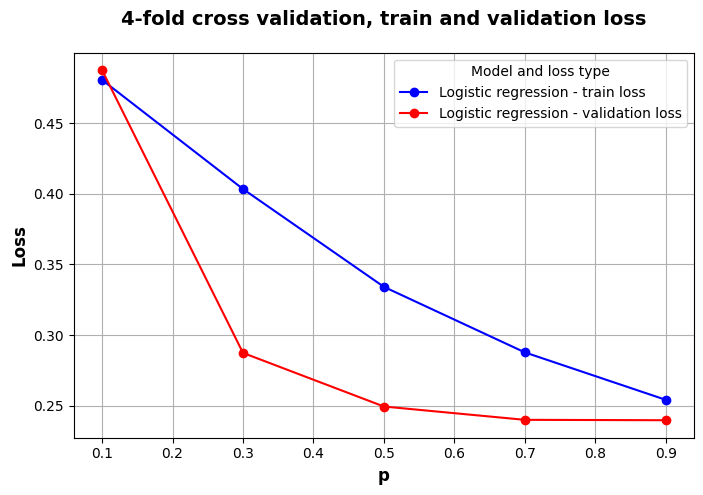

In [36]:
plt.figure(figsize=(8,5))
plt.plot(PERCENTAGES, log_train_losses, 'bo-', label=f'Logistic regression - train loss')
plt.plot(PERCENTAGES, log_val_losses, 'ro-', label=f'Logistic regression - validation loss')
plt.xlabel('p', fontsize=12, weight='bold')
plt.ylabel('Loss',  fontsize=12, weight='bold')
plt.title(f'{N_FOLDS}-fold cross validation, train and validation loss', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model and loss type")
plt.grid(True)
plt.show()

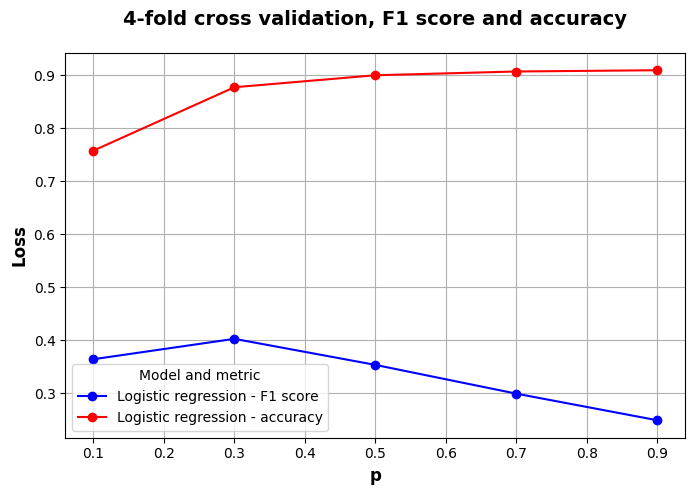

In [38]:
plt.figure(figsize=(8,5))
plt.plot(PERCENTAGES, log_f1s, 'bo-', label=f'Logistic regression - F1 score')
plt.plot(PERCENTAGES, log_accuracies, 'ro-', label=f'Logistic regression - accuracy')
plt.xlabel('p', fontsize=12, weight='bold')
plt.ylabel('Loss',  fontsize=12, weight='bold')
plt.title(f'{N_FOLDS}-fold cross validation, F1 score and accuracy', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model and metric")
plt.grid(True)
plt.show()

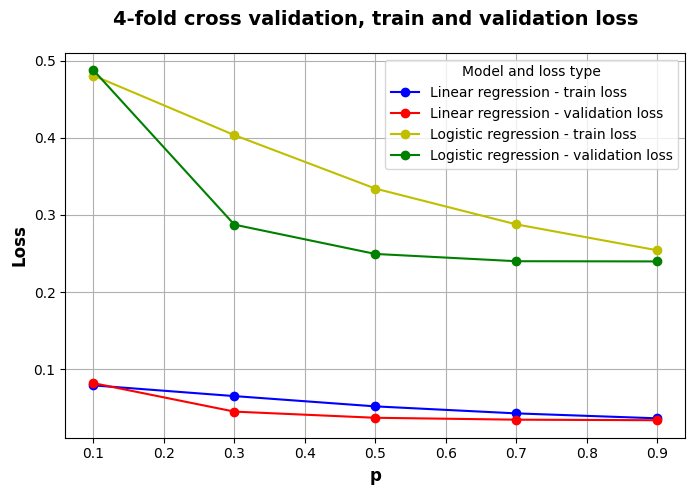

In [43]:
# putting all plots together

plt.figure(figsize=(8,5))
plt.plot(PERCENTAGES, lin_train_losses, 'bo-', label=f'Linear regression - train loss')
plt.plot(PERCENTAGES, lin_val_losses, 'ro-', label=f'Linear regression - validation loss')
plt.plot(PERCENTAGES, log_train_losses, 'yo-', label=f'Logistic regression - train loss')
plt.plot(PERCENTAGES, log_val_losses, 'go-', label=f'Logistic regression - validation loss')
plt.xlabel('p', fontsize=12, weight='bold')
plt.ylabel('Loss',  fontsize=12, weight='bold')
plt.title(f'{N_FOLDS}-fold cross validation, train and validation loss', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model and loss type")
plt.grid(True)

plt.savefig("img_notturne\\lin_vs_log_loss.pdf")

plt.show()


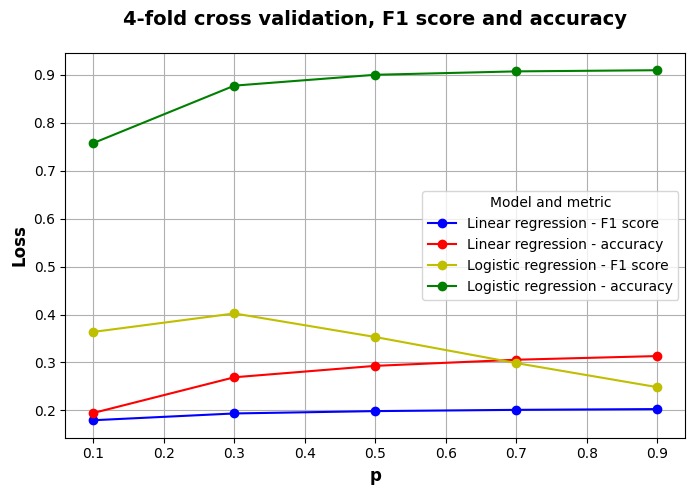

In [ ]:

plt.figure(figsize=(8,5))
plt.plot(PERCENTAGES, lin_f1s, 'bo-', label=f'Linear regression - F1 score')
plt.plot(PERCENTAGES, lin_accuracies, 'ro-', label=f'Linear regression - accuracy')
plt.plot(PERCENTAGES, log_f1s, 'yo-', label=f'Logistic regression - F1 score')
plt.plot(PERCENTAGES, log_accuracies, 'go-', label=f'Logistic regression - accuracy')
plt.xlabel('p', fontsize=12, weight='bold')
plt.ylabel('Loss',  fontsize=12, weight='bold')
plt.title(f'{N_FOLDS}-fold cross validation, F1 score and accuracy', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model and metric")
plt.grid(True)

plt.savefig("img_notturne\\lin_vs_log_metrics.pdf")

plt.show()

regularized logistic regression

In [10]:
PERCENTAGE = 0.3
N_FOLDS = 4
LEARNING_RATE = 0.05
THRESHOLD = 0.5
MAX_ITERS = 1000
INITIAL_W = np.ones(D)
LAMBDAS = np.logspace(-3, 0, 4)

folds = balanced_k_folds(y_train, N_FOLDS)

reg_train_losses = np.zeros(len(LAMBDAS))
reg_val_losses = np.zeros(len(LAMBDAS))
reg_f1s = np.zeros(len(LAMBDAS))
reg_accuracies = np.zeros(len(LAMBDAS))

# use the same folds as before
# folds = balanced_k_folds(y_train, N_FOLDS)

for j, lambda_ in enumerate(LAMBDAS):
    la_train_losses = np.zeros(N_FOLDS)
    la_val_losses = np.zeros(N_FOLDS)
    la_f1s = np.zeros(N_FOLDS)
    la_accuracies = np.zeros(N_FOLDS)
    
    for i in tqdm(range(N_FOLDS)):
        fold = folds[i]
        rest = np.setdiff1d(np.arange(N), fold)
            
        loc_y_val = y_train[fold]
        loc_x_val = x_train_norm[fold, :]
        loc_y_train = y_train[rest]
        loc_x_train = x_train_norm[rest, :]
        loc_x_train, loc_y_train = remove_percentage(loc_x_train, loc_y_train, PERCENTAGE)

        w, loc_train_loss =  reg_logistic_regression(loc_y_train, loc_x_train, lambda_, INITIAL_W, MAX_ITERS, LEARNING_RATE)
        la_train_losses[i] = loc_train_loss
        la_val_losses[i] = loss_logistic_regression(loc_y_val, loc_x_val, w)
        la_accuracies[i], la_f1s[i] = accuracy_f1(loc_y_val, loc_x_val, w, THRESHOLD)
        
    reg_train_losses[j] = np.mean(la_train_losses)
    reg_val_losses[j] = np.mean(la_val_losses)
    reg_f1s[j] = np.mean(la_f1s)
    reg_accuracies[j] = np.mean(la_accuracies)

100%|██████████| 4/4 [01:42<00:00, 25.51s/it]


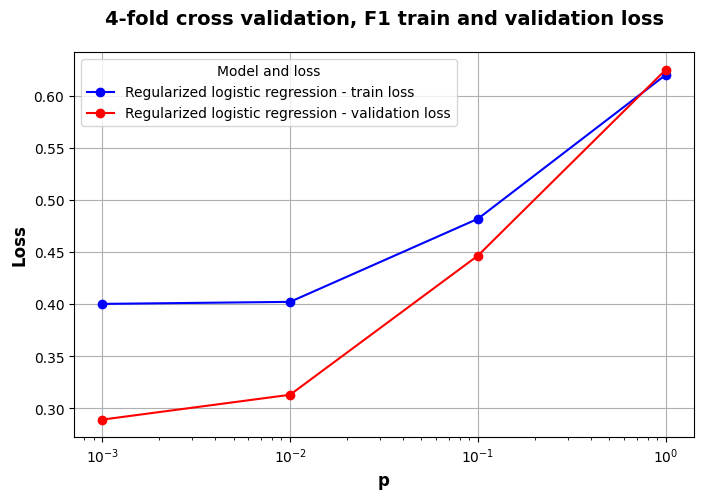

In [13]:
plt.figure(figsize=(8,5))
plt.plot(LAMBDAS, reg_train_losses, 'bo-', label=f'Regularized logistic regression - train loss')
plt.plot(LAMBDAS, reg_val_losses, 'ro-', label=f'Regularized logistic regression - validation loss')
plt.xlabel('p', fontsize=12, weight='bold')
plt.ylabel('Loss',  fontsize=12, weight='bold')
plt.title(f'{N_FOLDS}-fold cross validation, F1 train and validation loss', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model and loss")
plt.xscale('log')
plt.grid(True)

plt.savefig("img_notturne\\reg_loss.pdf")

plt.show()

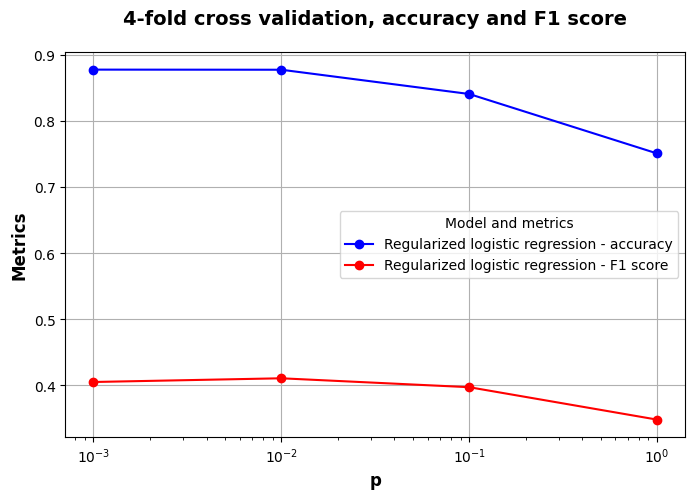

In [14]:
plt.figure(figsize=(8,5))
plt.plot(LAMBDAS, reg_accuracies, 'bo-', label=f'Regularized logistic regression - accuracy')
plt.plot(LAMBDAS, reg_f1s, 'ro-', label=f'Regularized logistic regression - F1 score')
plt.xlabel('p', fontsize=12, weight='bold')
plt.ylabel('Metrics',  fontsize=12, weight='bold')
plt.title(f'{N_FOLDS}-fold cross validation, accuracy and F1 score', fontsize=14, weight='bold', pad=20)
plt.legend(title="Model and metrics")
plt.xscale('log')
plt.grid(True)

plt.savefig("img_notturne\\reg_metrics.pdf")

plt.show()